## Part I: Read Data and Pre-Process

Import phcovid package

In [112]:
import numpy as np
import pandas as pd
import os, sys
package_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir) + os.sep +'phcovid'
sys.path.append(package_dir)

In [86]:
import phcovid
importlib.reload(phcovid)

<module 'phcovid' from 'C:\\Users\\yu.an\\Desktop\\Media\\phcovid\\phcovid\\phcovid.py'>

Use get_cases module to extract latest data regarding PH Covid-19 cases in an analysis friendly format

In [87]:
df = phcovid.get_cases()

In [113]:
#For use in graph analysis, we will create a column with case code [PHX] converted to numeric [X]
def parse_ints(s):
    num_list = []
    for i in s:
        num_list = num_list + [i.split('H')[-1]]
    return num_list
        

df['case_no_int'] = df['case_no'].apply(lambda x: x.split('H')[-1]).astype(int)
df['contacts_int'] = df['contacts'].apply(lambda x: parse_ints(x))

## Part II: Connected Components Analysis

<b>Step 1:</b> Create a graph to map all <u>direct connections</u> of each case.

In [114]:
#Create an undirected graph of all connections
contact_map = {}
def add_edge(s, d, curr_dict):
    try:
        curr_dict[s].append(d)
    except KeyError:
        curr_dict[s] = []
        curr_dict[s].append(d)

for row in df.itertuples():
    current = getattr(row, 'case_no_int')
    contact_list = getattr(row, 'contacts_int')
    for c in pd.Series(contact_list).unique():
        add_edge(int(current), int(c), contact_map)
        add_edge(int(c), int(current), contact_map)
    
    if(len(contact_list)==0):
        contact_map[int(current)] = []

for key in contact_map.keys():
    contact_map[key] = list(set(contact_map[key]))

<b>Step 2:</b> Use Depth First Search on the graph built in Step 1 to a.) identify <i>networks</i> of inter-connected cases and b.) count the number of networks and the number of cases in each network.

In [115]:
cnt = len(df)
visited = [False for i in range(1,cnt+2)]
visited_pre = [False for i in range(1,cnt+2)]
parent = [-1 for i in range(1,cnt+2)]
def dfs (v, g):
    #dfs from node v in graph (dict) g
    visited[v] = True
    for node in g[v]:
        if(not visited[node]):
            parent[node] = v
            dfs(node, g)
            
cnt_cc = 0
comp_list = {}
for i in range(1, cnt+1):
    if(not visited[i]):
        cnt_cc+=1
        dfs(i, contact_map)
        comp_list[cnt_cc-1] = []
        
        for j in range(1, cnt+1):
            if(not visited_pre[j] and visited[j]):
                visited_pre[j] = visited[j]
                comp_list[cnt_cc-1].append(j)

<b>a. Multiple cases, especially the initial ones can be traced to networks of 3+ people where transmission occured.</b> The largest network is comprised of 8 people: [12, 34, 35, 42, 43, 84, 86, 204].
<br>
<br>
<i>List of all networks with 3+ Cases shown below:</i>

In [116]:
print("List of all Networks with 3+ cases:")
for key in comp_list.keys():
    current_list = []
    if(len(comp_list[key])>=3):
        for i in comp_list[key]:
            current_list = current_list + ['PH' + str(i)]
        print(f'Network {key}: {current_list}')

List of all Networks with 3+ cases:
Network 3: ['PH5', 'PH6', 'PH38']
Network 6: ['PH9', 'PH27', 'PH28', 'PH29', 'PH30', 'PH31']
Network 9: ['PH12', 'PH34', 'PH35', 'PH42', 'PH43', 'PH84', 'PH86', 'PH204']
Network 16: ['PH21', 'PH65', 'PH66', 'PH67']
Network 28: ['PH41', 'PH44', 'PH87', 'PH112']
Network 33: ['PH49', 'PH52', 'PH183']
Network 35: ['PH51', 'PH134', 'PH135']
Network 140: ['PH169', 'PH170', 'PH176']


<b>b. Largest Network (Network 9) has loose connections and is split among multiple hospitals in NCR across 10 days. </b> <br>
<i>Network details are shown below:</i>

In [117]:
df[df['case_no_int'].isin(comp_list[9])]

,case_no,age,sex,nationality,residence,travel_history,symptoms,confirmation_date,facility,latitude,longitude,status,epi_link,date,contacts,num_contacts,case_no_int,contacts_int
22,PH12,56,Male,Filipino,Manila City,"Contact of PH42, PH43",,2020-03-09,Makati Medical Center,14.559177,121.014546,,,2020-03-08 16:00:00,"[PH42, PH43]",2,12,"[42, 43]"
47,PH34,72,Male,Filipino,Makati City,Husband of PH35,,2020-03-11,Lung Center of the Philippines,14.647821,121.045763,,,2020-03-10 16:00:00,[PH35],1,34,[35]
48,PH35,67,Female,Filipino,Makati City,Wife of PH34,,2020-03-11,Manila Doctors Hospital,14.582028,120.982657,,,2020-03-10 16:00:00,[PH34],1,35,[34]
55,PH42,51,Male,Filipino,Pasig City,Japan,,2020-03-11,Lung Center of the Philippines,14.647821,121.045763,,,2020-03-10 16:00:00,[],0,42,[]
56,PH43,47,Male,Filipino,Makati City,Wife is Sister of PH12; Close Contact of PH35,,2020-03-11,Lung Center of the Philippines,14.647821,121.045763,,,2020-03-10 16:00:00,"[PH12, PH35]",2,43,"[12, 35]"
97,PH84,38,Male,Filipino,Taguig City,Contact of PH43,,2020-03-13,St. Luke's Medical Center - Global City,14.555128,121.048256,,,2020-03-12 16:00:00,[PH43],1,84,[43]
99,PH86,48,Male,Filipino,Quezon City,Contact of PH43,,2020-03-13,Research Institute for Tropical Medicine,14.409523,121.037122,,,2020-03-12 16:00:00,[PH43],1,86,[43]
217,PH204,32,Female,Filipino,Makati City,Contact of PH35,,2020-03-18,Manila Doctors Hospital,14.582028,120.982657,,,2020-03-18 00:00:00,[PH35],1,204,[35]


<b>c. Certain people are also more inclined to spread to a large number of people, despite not being the first case in their network.</b><br>
<i>Shown below are cases with 3 or more contact cases:</i>

In [118]:
print("List of all cases with 3+ contacts:")
for key in contact_map.keys():
    current_list = []
    if(len(contact_map[key])>=3):
        for i in contact_map[key]:
            current_list = current_list + ['PH' + str(i)]
        print(f'Case: PH{key}')
        print(f'Contacts: {current_list}')

List of all cases with 3+ contacts:
Case: PH9
Contacts: ['PH27', 'PH28', 'PH29', 'PH30', 'PH31']
Case: PH43
Contacts: ['PH35', 'PH12', 'PH86', 'PH84']
Case: PH21
Contacts: ['PH65', 'PH66', 'PH67']
Case: PH35
Contacts: ['PH34', 'PH43', 'PH204']
Case: PH41
Contacts: ['PH112', 'PH44', 'PH87']
Case: PH44
Contacts: ['PH112', 'PH41', 'PH87']
Case: PH87
Contacts: ['PH112', 'PH41', 'PH44']
Case: PH112
Contacts: ['PH41', 'PH44', 'PH87']


<b>d. Currently, there are 274 unique networks, although the number may decrease as more case information is collected. Additionally, 7.14% of all cases come from networks of 2+ people, but this will increase as contact information is updated.</b>

In [119]:
print("Number of unique networks: ", cnt_cc)
print(f"Percentage of Transmissions in networks of 2+: {round(100*(1-cnt_cc/cnt),2)}%")

Number of unique networks:  674
Percentage of Transmissions in networks of 2+: 4.67%


## Part III: Monitoring

Much has already been said on the importance of <b>flattening the curve.</b> It can be shown that flattening the curve for the country begins with flattening the curve for each of the networks. That is, we should stop the networks of connected cases from growing. This can be accomplished with appropriate personal hygeine measures and social distancing whenever possible. 

<b>Use get_case_plot to show the growth of confirmed cases in PH</b>
<br>
<br><i>As of today, the growth of total PH cases is still rising</i>

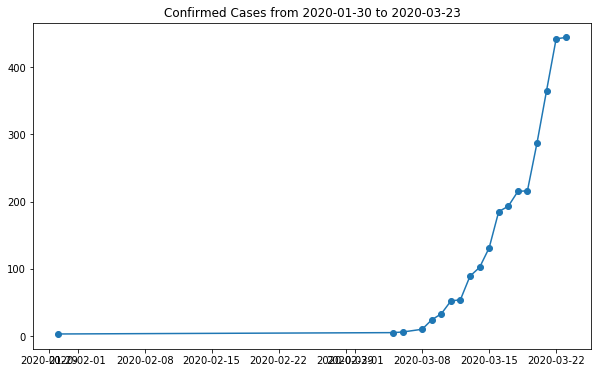

In [140]:
import phcovid_plot
import importlib
importlib.reload(phcovid_plot)
phcovid_plot.get_case_plot(df)

Use start_date functionality. <i>Plot only cases in March.</i>

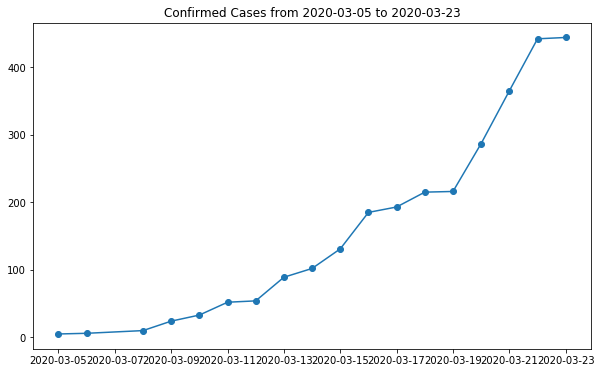

In [141]:
phcovid_plot.get_case_plot(df, start_date="03-02-20")

### Monitoring Large Networks

<b>Growth of confirmed cases within networks</b>
<br><i>Contact tracing and quarantine recommendations to large networks are important.</i>

<u>Case growth within Network 9:</u> <i>Case growth in Network 9 is seen to be flattening, with the latest case recorded 3/18/20.
This could indicate that the quarantine and preventive measures imposed on this network has been effective. Although we need to wait for more details and contact tracing of new cases to confirm. </i>

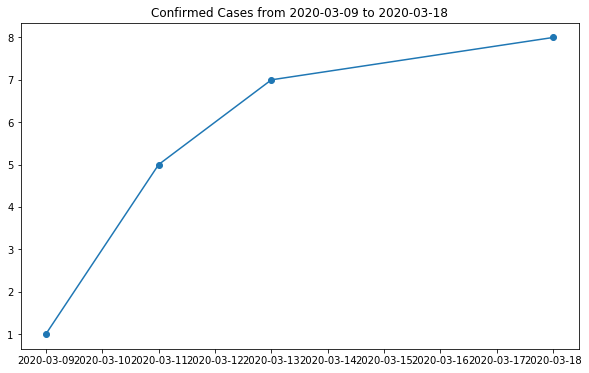

In [142]:
phcovid_plot.get_case_plot(df[df['case_no_int'].isin(comp_list[9])])

<u>Case growth within Network 6</u>

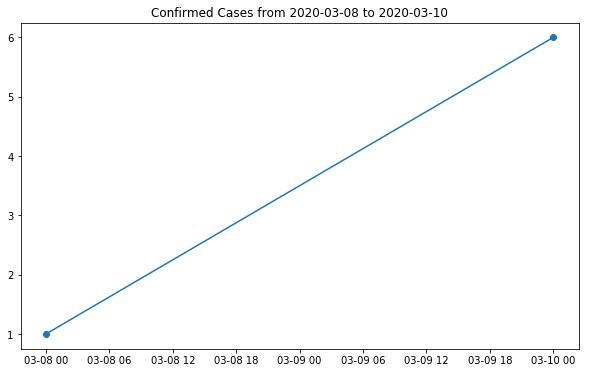

In [143]:
phcovid_plot.get_case_plot(df[df['case_no_int'].isin(comp_list[6])])

<u>Case growth among contacts of PH43:</u><i> No new cases among contacts of PH43 since 3/13/20</i>

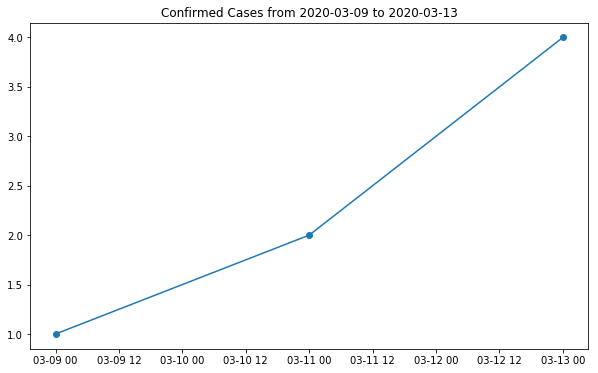

In [144]:
phcovid_plot.get_case_plot(df[df['case_no_int'].isin(contact_map[43])])